In [1]:
library(igraph)
library(ggplot2)
library(tidyverse)
library(jsonlite)
library(reshape2)
library(gridExtra)
options(rgl.useNULL = TRUE)
library(rgl)
library(RColorBrewer)
library(plotly)


source("func_task1.R")



Caricamento pacchetto: 'igraph'


I seguenti oggetti sono mascherati da 'package:stats':

    decompose, spectrum


Il seguente oggetto `e mascherato da 'package:base':

    union


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.0     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.2.0
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x lubridate::%--%()      masks igraph::%--%()
x dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
x purrr::compose()       masks igraph::compose()
x tidyr::crossing()      masks igraph::crossing()
x dplyr::filter()        masks stats::filter()
x dplyr::lag()           masks stats::lag()
x purrr::simplify()      masks igraph::simplify()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Caricamento pacchetto: 'js

In [2]:
#here I set the function to establish the plot dimension depending on the plot 
options(repr.plot.width=6, repr.plot.height=4)
set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

# Granovetter's bounded confidence model

## 1.1 Bandwagon effect

In [3]:
#model for the uniform distribution -> counts how many people are activated
model <- function(th, tsteps, r0, N) {
    data <- matrix(, nrow = tsteps, ncol = 2)
    for(t in 1:tsteps) {
        data[t, 2] <- r0
        data[t, 1] <- t
        r1 <- round(length(th[which(th <= r0)]) / N, 2)
        r0 <- r1   
    }
    return(data)
}

Here we veify the high unstability of a distribution like this: even a small perturbation changes completely the outcome

In [4]:
thresholds <- seq(from = 0, to = 1, by = 0.01)
N <- length(thresholds)
tsteps <- 120
r <- 0

#here I set the small perturbation by changing just one element in the system
#I changed the second element, but, of course, I could have changed any element, the result does not change
thresholds2 <- thresholds
thresholds2[2] <- 0.02

bandw <- model(thresholds, tsteps, r, N)
bandw2 <- model(thresholds2, tsteps, r, N)

bandwtot <- data.frame("tsteps" = bandw[, 1], "F1" = bandw[, 2], "F2" = bandw2[, 2])

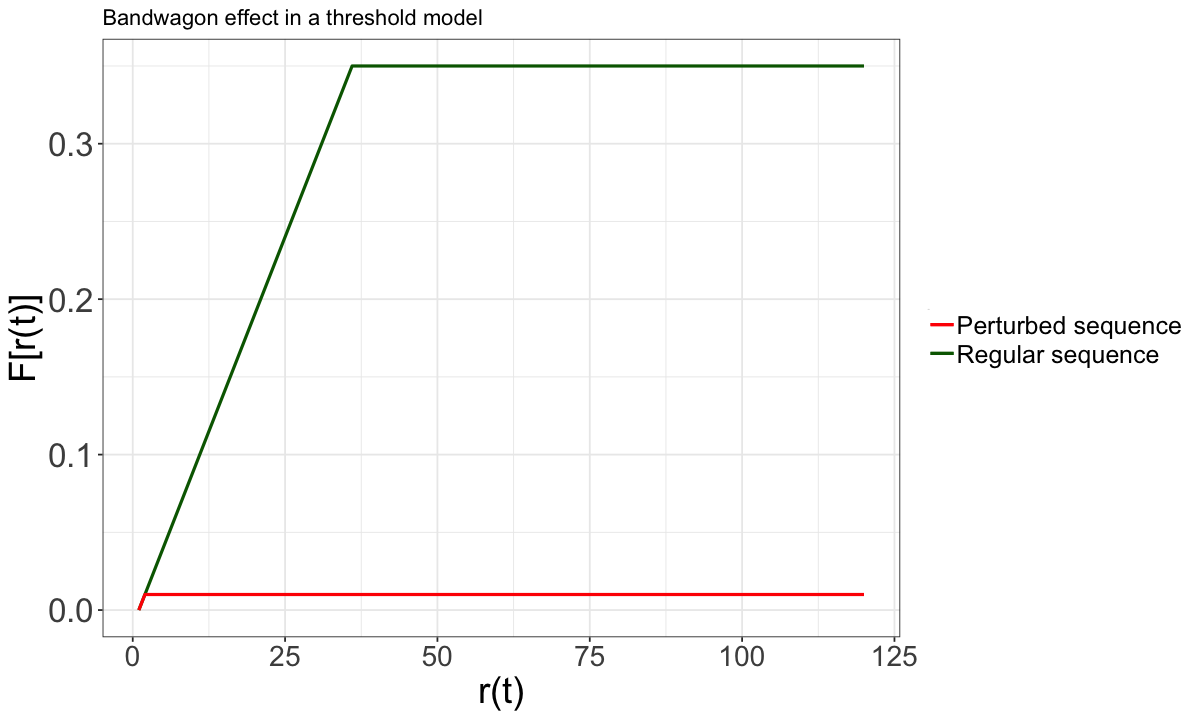

In [6]:
set_plot_dimensions(10, 6)
bw <- ggplot(data = bandwtot) +
    theme_bw() +
    theme(axis.title = element_text(size = 22), axis.text.x = element_text(size = 17), axis.text.y = element_text(size = 20)) +
    theme(legend.title = element_text(size = 0.5), legend.text = element_text(size = 15)) +
    scale_color_manual(values = c('Regular sequence' = 'darkgreen', 'Perturbed sequence' = 'red')) +
    geom_line(aes( x = tsteps, y = F1, colour = "Regular sequence"), linewidth = .9) +
    geom_line(aes( x = tsteps, y = F2, colour = "Perturbed sequence"), linewidth = .9) +
    labs(title = "Bandwagon effect in a threshold model", y = "F[r(t)]", x = "r(t)")

bw

## 1.2 Recursive method

Normal distribution: we sample from a normal pdf the frequency distribution and we check the change in the equilibrium point by changing the standard deviation

In [3]:
#function that gives me the frequencies of the threshold taken from a normal distribution
norm_model <- function(N, mu, sd) {

    cf <- round(pnorm(seq(from = 1, to = N, by = 1), mu, sd) * N, 0) #for each frequency I define the sum of the thresholds, I use round() in order to have an integer value
    f <- rep(0, N)
    f[1] <- cf[1]
    for( i in 2:N){
        f[i] <- cf[i] - cf[i - 1] #frequencies of the thresholds obtained from the cumulative
    }

return(f)
}

In [4]:
#function that counts the number of people that have joined the riot without considering social structures or distances 
#if we consider that, once an agent has joined the riot they will not change their mind, we can just move through the vector of the thresholds
#without using more timesteps
r_count <- function(freq, th) {
    r <- 0
    if(freq[1] == 0){
        r <- 0
    } else {
        for( i in 1:length(th)){
            if(r >= th[i]){
                r <- r + freq[i]
            } else {
                break
            }
        }
    }
return(r)
}


In [63]:
N <- 100
mean <- 0.25 * N
th <- c(0, seq(0:(N - 2)))

Here I want to compute the value of the $r_e$ both for different values of the standard deviation $\sigma$ and for different values of $\mu$

In [64]:
#vector for the 1D plot
sd_v_1  <- (seq(from = 0.01, to = 6, by = 0.005)*N)
mu <- (seq(from = 0.01, to = 1, by = 0.005)*N)
r <- rep(0, length(sd_v_1))
for( j in 1:length(sd_v_1)){
    freq <- norm_model(N, mean, sd_v_1[j])
    r[j] <- r_count(freq, th)
}

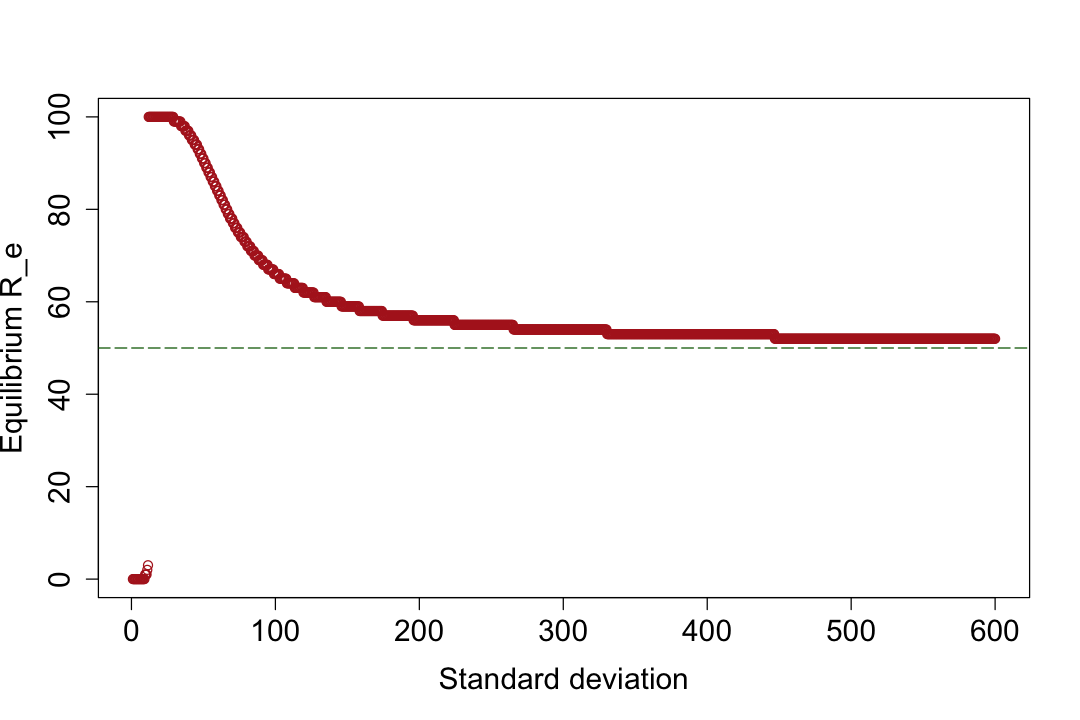

In [65]:
set_plot_dimensions(9,6)
par(bg = "white")
plot(sd_v_1, r, col = "firebrick", xlab = "Standard deviation", ylab = "Equilibrium R_e", cex.lab = 1.5, cex.axis = 1.5)
abline(h = 50, col = "darkgreen", lty = 5)

In [54]:
#matrix for the 2D plot
sd_v  <- (seq(from = 0.01, to = 3, by = 0.005)*N)
mu_v <- (seq(from = 0.01, to = 1, by = 0.005)*N)
rm <- matrix(, nrow = length(sd_v), ncol = length(mu_v))
for( j in 1:length(sd_v)){
    for(i in 1 : length(mu_v)){
        freq <- norm_model(N, mu_v[i], sd_v[j])
        rm[j, i] <- r_count(freq, th)
    }
}


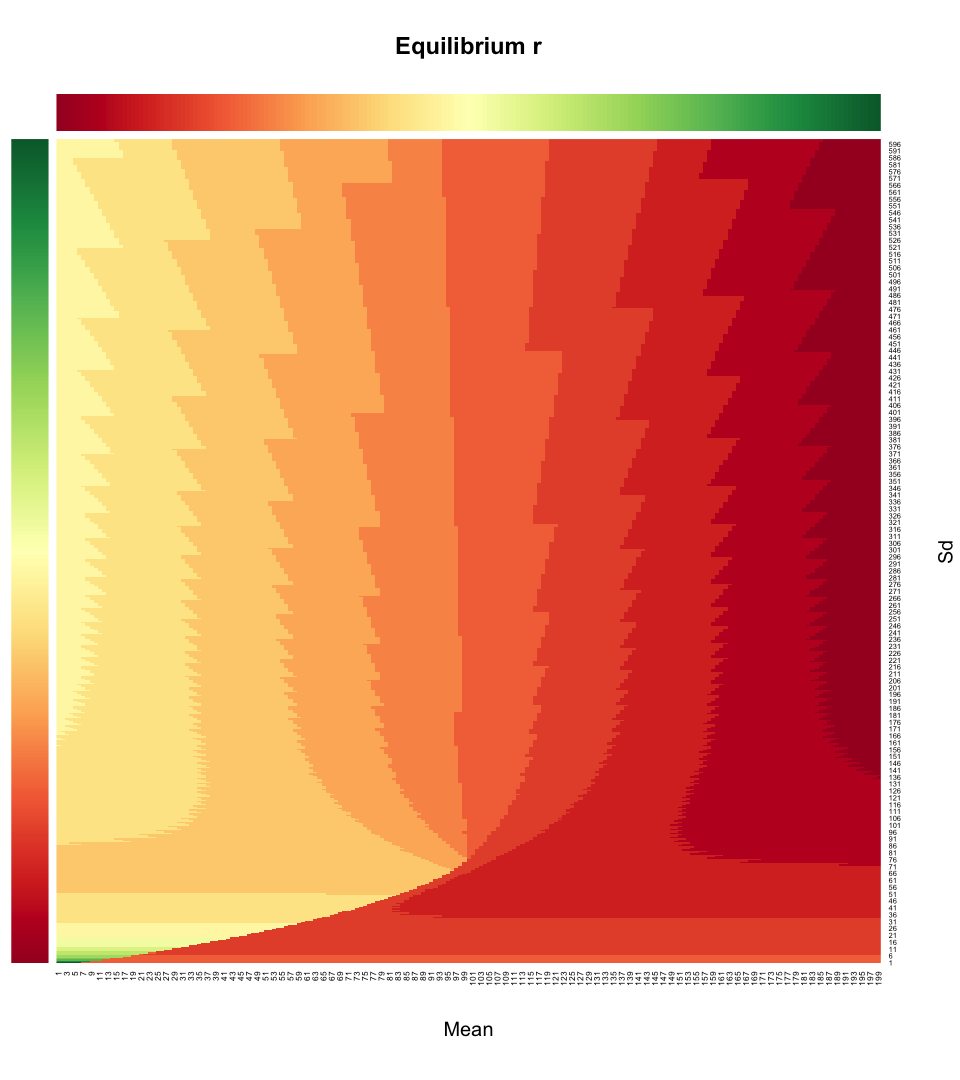

In [57]:
set_plot_dimensions(8, 9)
coul <- colorRampPalette(brewer.pal(11, "RdYlGn"))(20)
coulside <- colorRampPalette(brewer.pal(11, "RdYlGn"))(length(mu_v))
coulside2 <- colorRampPalette(brewer.pal(11, "RdYlGn"))(length(sd_v))
par(bg="white")
heatmap(rm, Colv = NA, Rowv = NA, col = coul, scale = "row", ColSideColors=coulside, RowSideColors = coulside2, xlab = "Mean",cex.lab = 1.8,
cex.axis = 1.8, ylab = "Sd", main = "Equilibrium r")

## Graphs

In [5]:
#function that counts the number of elements in the graph that have been activated
r_count.g <- function(freq, th, act) {
    r <- 0
    if(freq[1] == 0){
        r <- 0
    } else {
        for( i in 1:length(th)){
            if(r >= th[i]){
                r <- r + freq[i]
                act[1:i] <- 1 
            } else {
                break
            }
        }

    }
return(act)
}

In [6]:
#function to assign to each vertex a threshold value following a certain distribution
thresholds_vertex <- function(freq, th){
    v <- c()
    for(i in 1: length(th)){
        v <- c(v, rep(th[i], freq[i]))
    } 
    if(length(v) < length(th)) {
        v <- c(v, rep(0, length(th) - length(v)))
    }
    #v <- sample(v)
    return(v)
}

In [7]:
#counts how many elements of a certain graph have been activated considering the social structure too
#fr and ot are respectively the weight given to a friendship and the value given to a stranger that joins the riot
activation_friendship <- function(freq, th, act, vertex, g, fr, ot) { 
    r <- 3 #number of elements with threshold zero I put inside the vector as the "istigators"
    if(freq[1] == 0){ 
        r <- 3
    } else {
        for( i in 1:length(vertex)){
            f <- 0
            for(j in 1:length(vertex)) {
                if(are_adjacent(g, vertex[i], vertex[j])){ 
                    if(act[j] == 1){
                    f <- f + fr
                    }
                } 
            } 
            r <- r + f #Here I add all the friendships that vertex[i] has
            if(r >= th[i]){ #here I check if I can activate the vertex[i]
                r <- r + ot                   
                act[1:i] <- 1
                r <- r - f #i set r to the original value
            } else {
                break
            }
        }
    } 
    return(list(length(act[act ==1]), act))
    }

In [9]:
set.seed(1234)
N <- 100
#now I look for the equilibrium point, by applying the model
#Let's try to do so by creating a erdos-renyi network
#we want a graph with n nodes and m edges or with p probability of creating an edge G(n, m)
g <- erdos.renyi.game(N,0.1, type = "gnp", directed = FALSE, loops = FALSE)


In [10]:
set.seed(1234) #to make them reproducible
V(g)$f <- norm_model(N, mu = 0.25*N, sd = 0.12*N) #a ogni vertice attribuisco una threshold
V(g)$act <- rep(0, length(V(g)) - 2, 1, 1)
#V(g)$act <- sample(V(g)$act)
th <- c(0, seq(0:(N - 2)))

#activation function -> changes the colour if a certain condition is respected
V(g)$act <- r_count.g(V(g)$f,th, V(g)$act)
V(g)$color[V(g)$act == 0] <- "red"
V(g)$color[V(g)$act == 1] <- "darkgreen"
length(V(g)$color[V(g)$color == "darkgreen"])


[1] 100

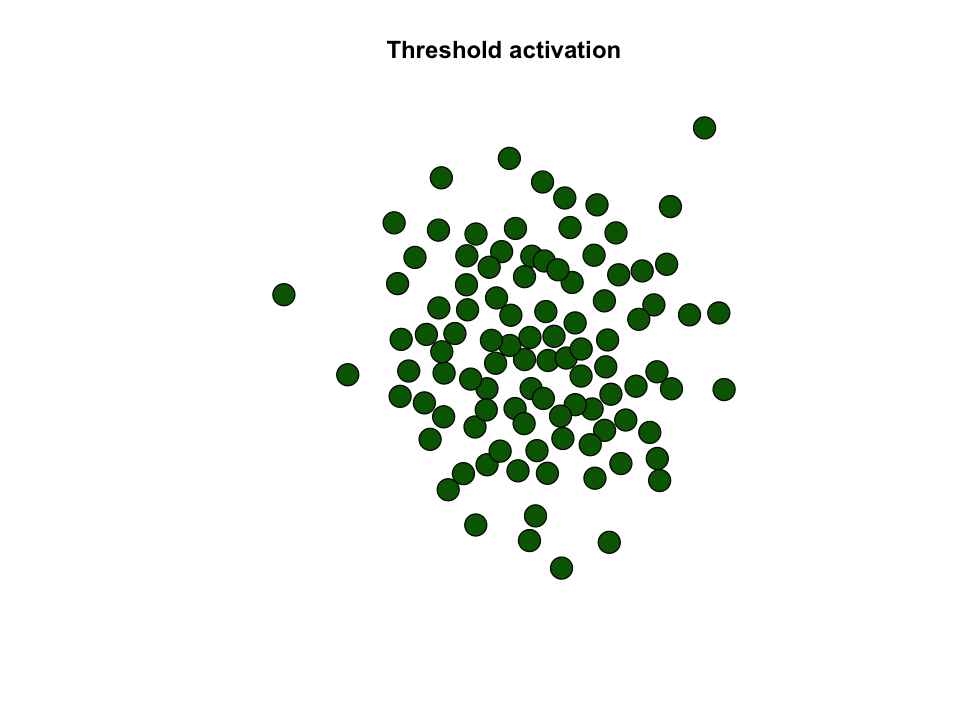

In [11]:
# lets plot the network -> we did not plot the edges because in this case we are considering neither the social structure nor the distribution in space
set.seed(1234)
set_plot_dimensions(8,6)
par(bg= "white")
plot(g,
     vertex.color = V(g)$color,
     vertex.label = NA,
     vertex.label.color = "black",
     vertex.size = 10,
     edge.color = "white",
     main = "Threshold activation")

### 1.3 Effect of the introduction of the social structure

In [13]:
#Now, in order to achieve also the social structure result, we need to work on edges also
set.seed(1234)
freq <- norm_model(N, 0.25*N, 0.1*N )
V(g)$threshold <- thresholds_vertex(freq, th) #in this way I have assigned a threshold to all my vertices

In [14]:
V(g)$act <- rep(0, length(V(g)))
#V(g)$act <- sample(V(g)$act)
acti <- activation_friendship(freq, th, V(g)$act, V(g), g, 4, 1)

In [15]:
V(g)$act <- acti[[2]]
V(g)$color[V(g)$act == 0] <- "red"
V(g)$color[V(g)$act == 1] <- "darkgreen"
length(V(g)$color[V(g)$color == "darkgreen"])

[1] 100

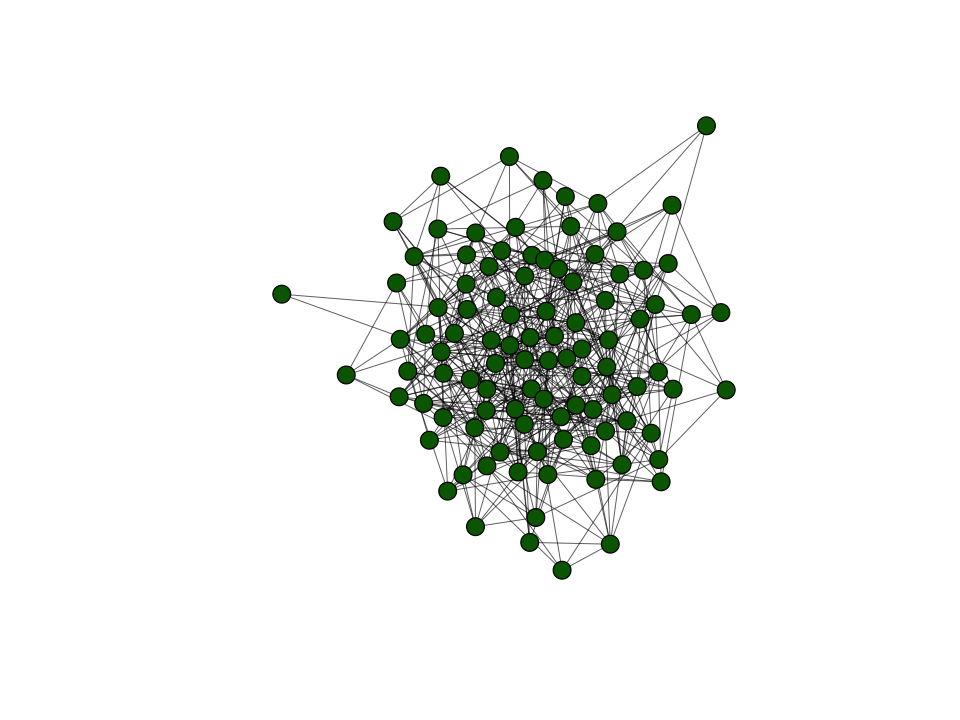

In [19]:
# lets plot the network
set.seed(1234)
par(bg= "white")
lay=layout_with_fr(g)
plot(g,
     vertex.color = V(g)$color,
     vertex.label.color = "black",
     vertex.label = NA,
     vertex.size = 8,
     edge.color = "black",
     edge.width = 0.5,
     layout=lay)

As shown in the plot below, the results are always either 0 or 100 even if we insert a social structure inside our model, the social structure helps to anticipate the critical value and mantain the number of people that have been activated at 100. Despite this differences, considering a social structure with a normal distribution does not change the results in such a significant way, as we were expecting.

In [61]:
sd.g <- seq(from = 1, to = 100, by = 1)
set.seed(1234)
r.g <- rep(0, length(sd.g))
for(i in 1:length(sd.g)){  
    freq <- norm_model(N, 25, sd.g[i])
    V(g)$threshold <- thresholds_vertex(freq, th)
    V(g)$act <- rep(0, length(V(g)))
    #V(g)$act <- sample(V(g)$act)
    acti <- activation_friendship(freq, th, V(g)$act, V(g), g, 14, 1)
    V(g)$act <- acti[[2]]
    r.g[i] <- acti[[1]]
}


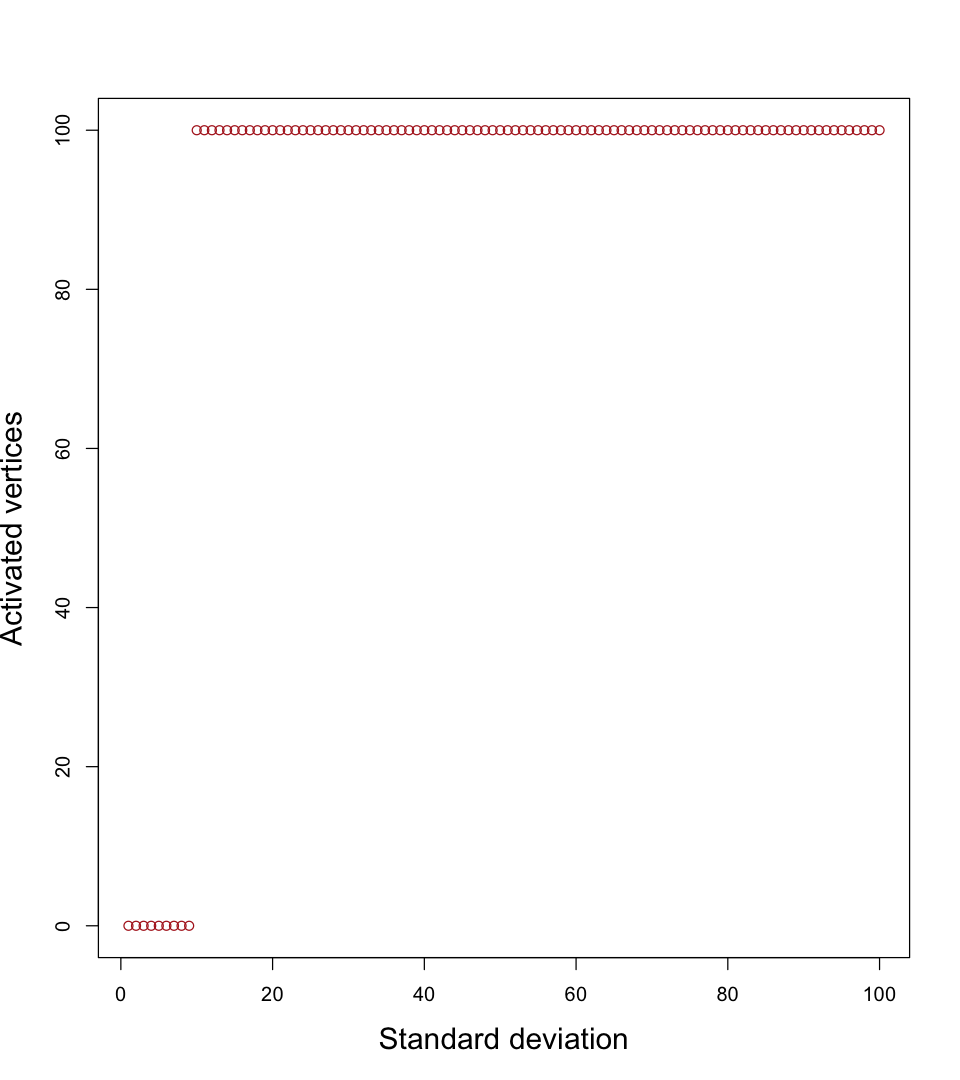

In [62]:
par(bg = "white")
plot(sd.g, r.g, col = "firebrick", xlab = "Standard deviation", ylab = "Activated vertices", cex.lab = 1.5)

## Neighbourhood and segregation influence

In this part of the task we would like to add to the model the concept of the distance between people (vertices). To do so, we implement this task with the segregation model of the task 1.

In [10]:
set.seed(1234)
n = 1000
m = 3000
K = 100
p = 0.5
max_step = 5*m*log(m)  #mlog(m) minimum time to reach convergence
num_saves = 50 # num of saved steps of G (there will be actually 2 more: initial and final)

#only works for  type_G0 = 'random', type_attr = 'uniform':
type_G0 = 'random'
type_attr = 'binormal'
type_p = "unique"

network = evolve_network (n, m, K, p, max_step, type_G0, type_attr, type_p, num_saves) #create and evolve the network
attributes=network[[2]] #extract the attributes
Ei = calculate_Ei(network,K) #calculate simulated results

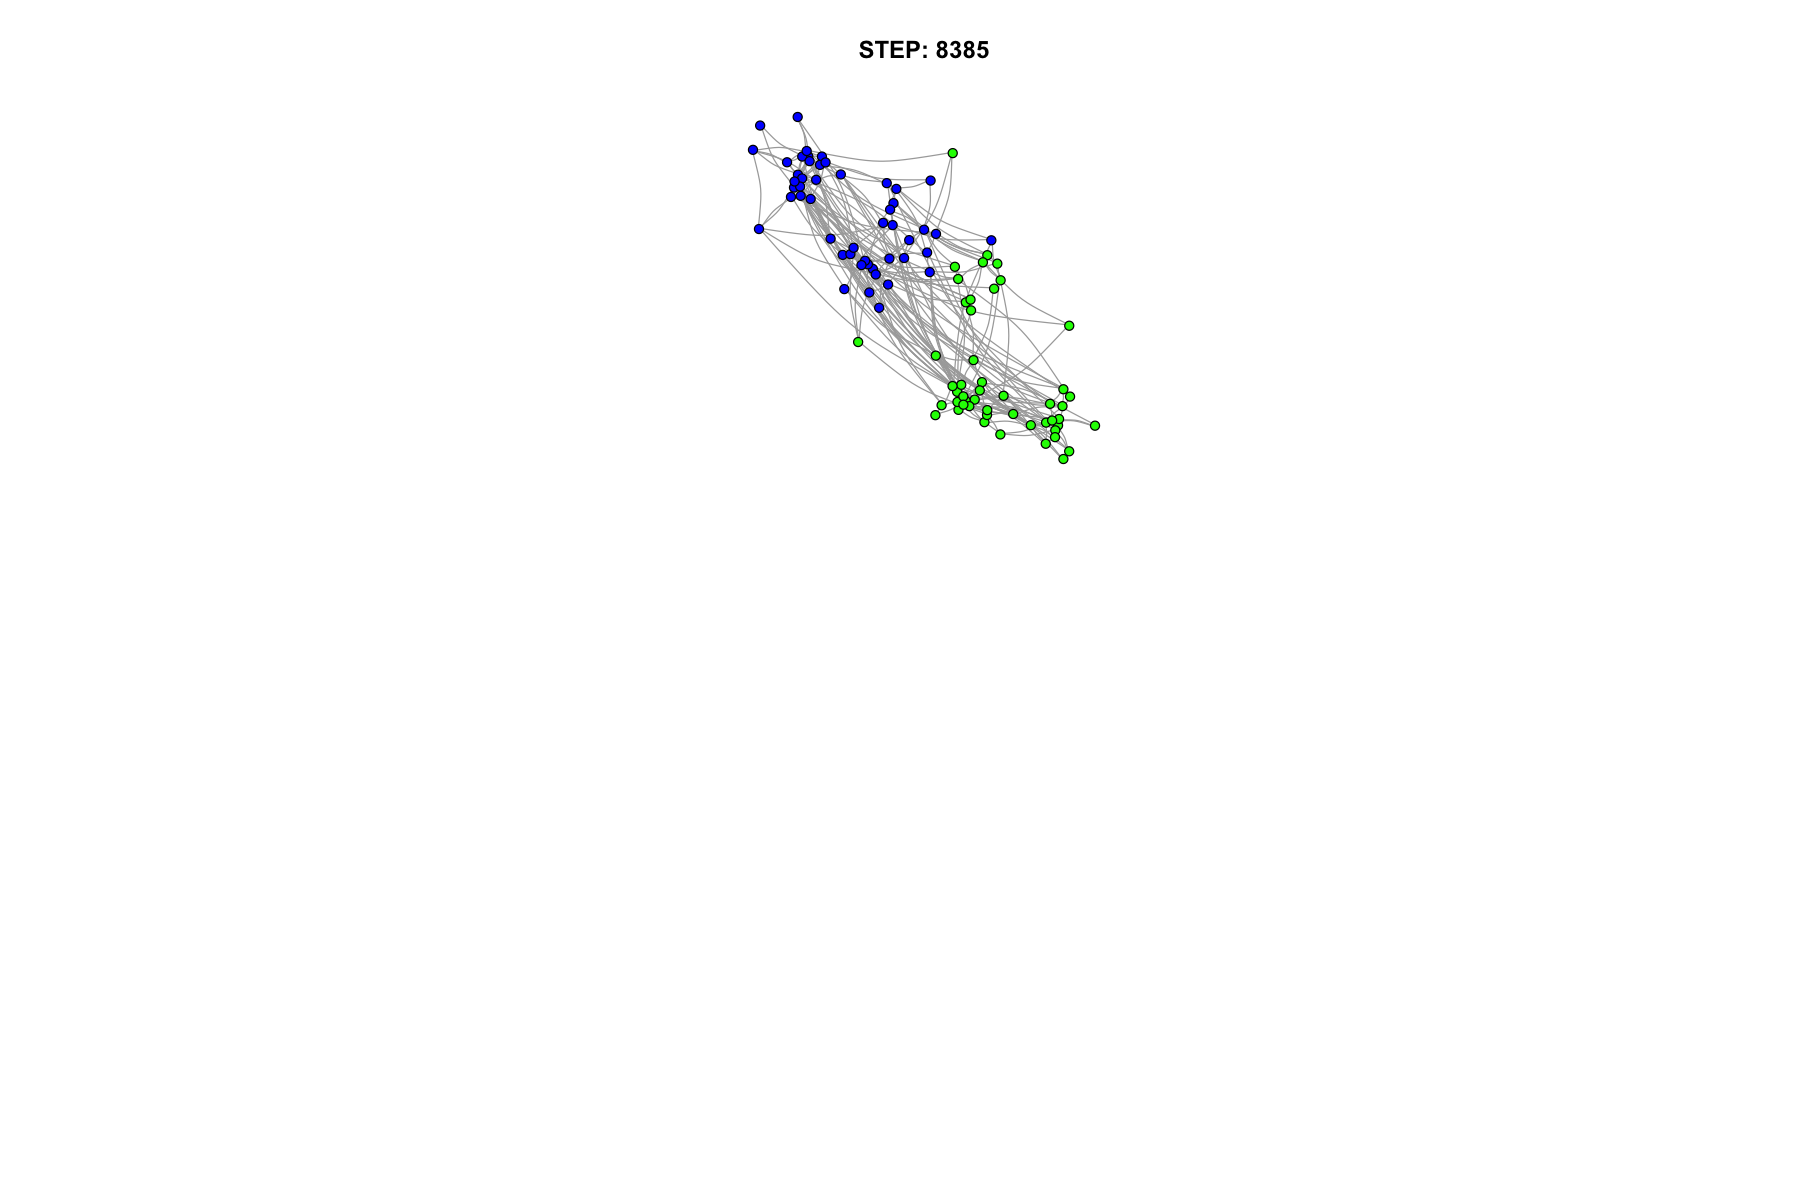

In [18]:
par(bg = "white")
set.seed(1234)
choosen_steps=c(num_saves) #which steps of G we want to plot
g.segr <- plot_graphs(K, network, max_step,num_saves,choosen_steps)

In [19]:
set.seed(1234)
freq.segr <- norm_model(n, 0.20*n, 0.12*n )
th.segr <- c(0, seq(0:(n - 2)))
V(g.segr)$threshold <- thresholds_vertex(freq.segr, th.segr) #in this way I have assigned a threshold to all my vertices


In [20]:
V(g.segr)$act <- c(rep(0, length(V(g.segr)) - 3), rep(1, 3))
V(g.segr)$act <- sample(V(g.segr)$act)
acti <- activation_friendship(freq.segr, th.segr, V(g.segr)$act, V(g.segr), g.segr, 80, 0.5)
V(g.segr)$act <- acti[[2]]
V(g.segr)$color[V(g.segr)$act == 0] <- "red"
V(g.segr)$color[V(g.segr)$act == 1] <- "darkgreen"

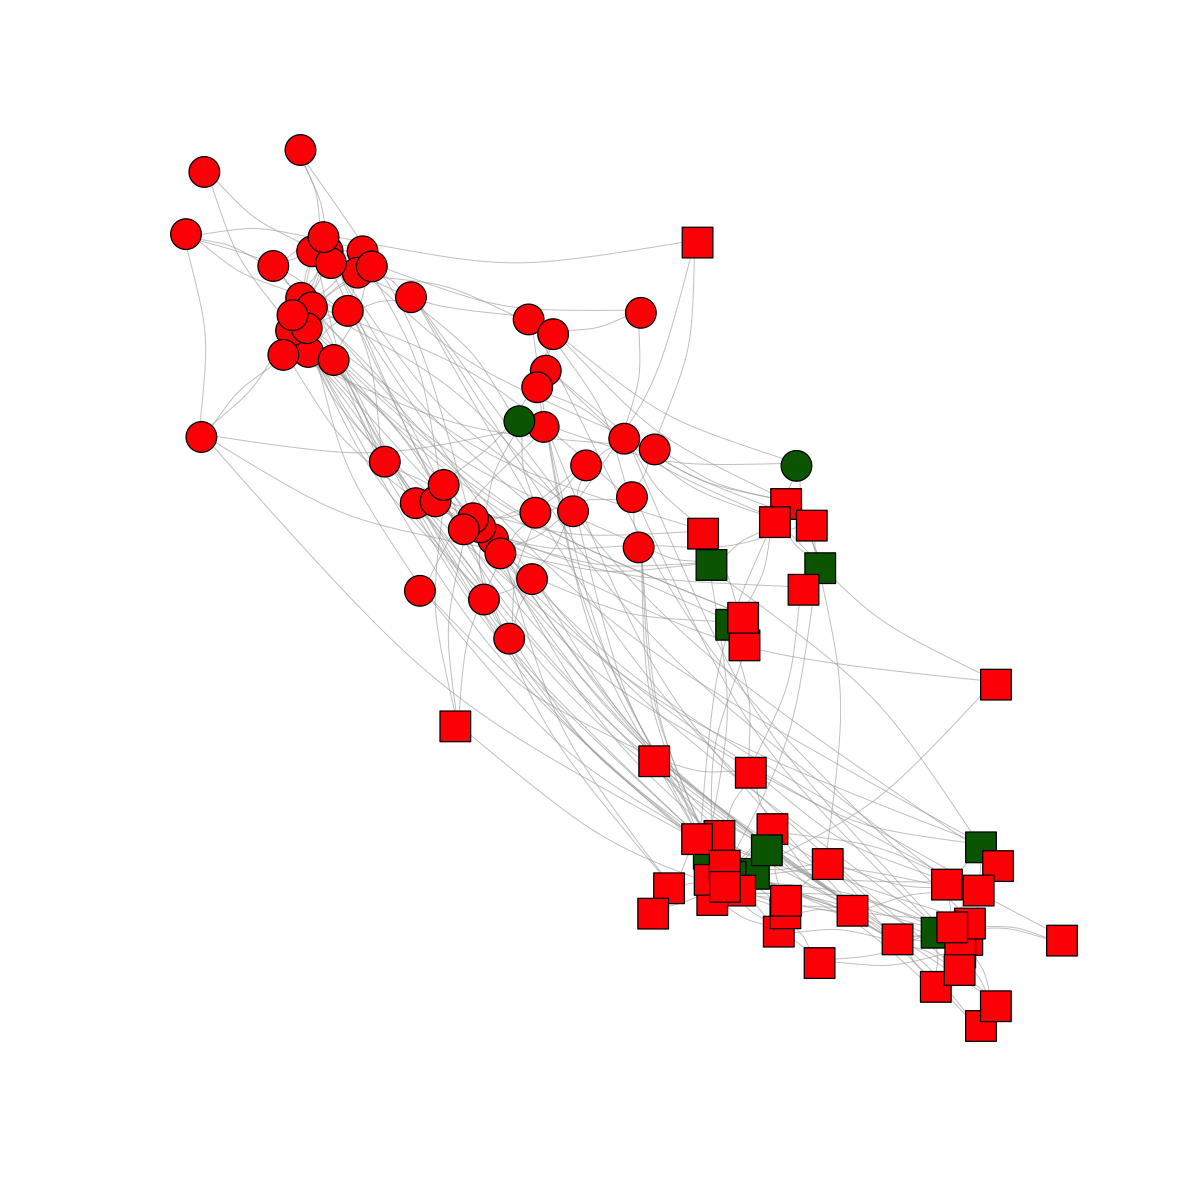

In [25]:
# lets plot the network
set.seed(1234)
par(bg= "white")

attr=attributes
shape_vertex=attr
shape_vertex[shape_vertex<=0.5]='square'
shape_vertex[shape_vertex!='square']='circle'


lay=layout_with_fr(g.segr)
size_=7

set_plot_dimensions(10,10)
plot(g.segr,vertex.color=V(g.segr)$color,vertex.shape=shape_vertex,vertex.label=NA, edge.width = 0.5,
    edge.curved=0.2,vertex.size=size_,layout=lay, main.size = 10)
